<a href="https://colab.research.google.com/github/cherryng/MLcourse/blob/main/H4_Q2_tutorial_spirals_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Feedforward neural networks in PyTorch

Mothers and Machine Learning

April 6, 2022

Code by Lauren Hayward, Juan Carrasquilla, and Mohamed Hibat Allah

## Create and plot the data set


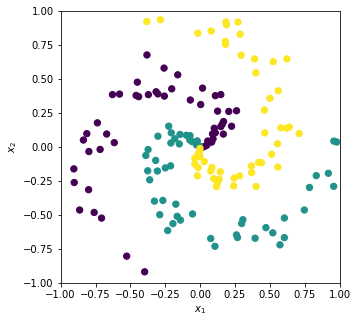

In [2]:
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np

N = 50 # number of points per branch
K = 3  # number of branches

N_train = N*K # total number of points in the training set
x_train = np.zeros((N_train,2)) # matrix containing the 2-dimensional datapoints
t_train = np.zeros(N_train, dtype='uint8') # labels (not in one-hot representation)

mag_noise = 0.3  # controls how much noise gets added to the data
dTheta    = 4    # difference in theta in each branch

### Data generation: ###
for j in range(K):
  ix = range(N*j,N*(j+1))
  r  = np.linspace(0.01,1,N) # radius
  th = np.linspace(j*(2*np.pi)/K,j*(2*np.pi)/K + dTheta,N) + np.random.randn(N)*mag_noise # theta
  x_train[ix] = np.c_[r*np.cos(th), r*np.sin(th)]
  t_train[ix] = j

### Plot the data set: ###
fig = plt.figure(1, figsize=(5,5))
plt.scatter(x_train[:, 0], x_train[:, 1], c=t_train, s=40)#, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.savefig('spiral_data.pdf', bbox_inches="tight")
plt.show()

In [ ]:
#Run this cell if you want to save a pdf plot of the dataset:
#files.download('spiral_data.pdf')

## Define the network architecture

In [12]:
%matplotlib inline
from IPython import display

import time
import torch

class FeedforwardNN(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(FeedforwardNN, self).__init__()

        #layer sizes:
        self.input_size = input_size
        self.output_size = output_size

        #functions used within the Feedforward NN:
        self.linear1 = torch.nn.Linear(self.input_size, self.output_size)
        self.relu    = torch.nn.ReLU() 
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax()      
    def forward(self, x):
        #Layer 1:
        linear1_out = self.linear1(x)
        h1 = self.softmax(linear1_out)

        #Network output:
        y = h1

        return y

input_size = 2
output_size = K
model = FeedforwardNN(input_size, output_size)

### Store the input data as a PyTorch tensor ###
x_train = torch.tensor(x_train, dtype = torch.float)

### One hot encoding ###
t_onehot = np.zeros((t_train.size, K))
t_onehot[np.arange(t_train.size),t_train] = 1
t_onehot = torch.tensor(t_onehot, dtype = torch.float)

### Use backpropagation to minimize the cost function using the gradient descent algorithm: ###
learning_rate = 1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Cost function: ###
cost_func = torch.nn.CrossEntropyLoss()

N_epochs = 10000 # number of times to run gradient descent

## Training

Final Training cost 0.902227
Final Training accuracy 0.653333



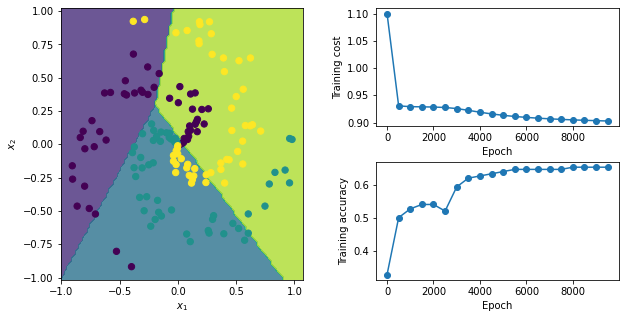

In [13]:
epoch_list    = []
cost_training = []
acc_training  = []

############ Function for plotting: ############
def updatePlot():

    ### Generate coordinates covering the whole plane: ###
    padding = 0.1
    spacing = 0.02
    x1_min, x1_max = x_train[:, 0].min() - padding, x_train[:, 0].max() + padding
    x2_min, x2_max = x_train[:, 1].min() - padding, x_train[:, 1].max() + padding
    x1_grid, x2_grid = np.meshgrid(np.arange(x1_min, x1_max, spacing),
                         np.arange(x2_min, x2_max, spacing))

    torch_input = torch.tensor(np.c_[x1_grid.ravel(), x2_grid.ravel()], dtype = torch.float)
    NN_output = model(torch_input)
    predicted_class = np.argmax(NN_output.detach().numpy(), axis=1)

    ### Plot the classifier: ###
    plt.subplot(121)
    plt.contourf(x1_grid, x2_grid, predicted_class.reshape(x1_grid.shape), K, alpha=0.8)
    plt.scatter(x_train[:, 0], x_train[:, 1], c=t_train, s=40)
    plt.xlim(x1_grid.min(), x1_grid.max())
    plt.ylim(x2_grid.min(), x2_grid.max())
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')

    ### Plot the cost function during training: ###
    plt.subplot(222)
    plt.plot(epoch_list,cost_training,'o-')
    plt.xlabel('Epoch')
    plt.ylabel('Training cost')

    ### Plot the training accuracy: ###
    plt.subplot(224)
    plt.plot(epoch_list,acc_training,'o-')
    plt.xlabel('Epoch')
    plt.ylabel('Training accuracy')
############ End of plotting function ############

### Train for several epochs: ###
for epoch in range(N_epochs):

    optimizer.zero_grad() # sets the gradients to zero (necessary since PyTorch accumulates the gradients)
    NN_output = model(x_train) # Neural network output
    cost = cost_func(NN_output, t_onehot)
    cost.backward() #computes the gradients
    optimizer.step() #updating the parameters 

    ### Update the plot and print results every 500 epochs: ###
    if epoch % 500 == 0:
        predicted_class = np.argmax(NN_output.detach().numpy(), axis=1)
        accuracy = np.mean(predicted_class == t_train)
        
        epoch_list.append(epoch)
        cost_training.append(cost.detach().numpy())
        acc_training.append(accuracy)
        
        ### Update the plot of the resulting classifier: ###
        fig = plt.figure(2,figsize=(10,5))
        fig.subplots_adjust(hspace=.3,wspace=.3)
        plt.clf()
        updatePlot()
        display.display(plt.gcf())
        print("Iteration %d:\n  Training cost %f\n  Training accuracy %f\n" % (epoch, cost, accuracy) )
        display.clear_output(wait=True)
        # time.sleep(0.1) #Uncomment this line if you want to slow down the rate of plot updates

plt.savefig('spiral_results.pdf', bbox_inches="tight")
print("Final Training cost %f\nFinal Training accuracy %f\n" % (cost, accuracy) )

In [ ]:
#Run this cell if you want to save a pdf plot of the results:
#files.download('spiral_results.pdf') 

In [14]:
#Including one hidden layer with 4 nodes

class FeedforwardNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardNN, self).__init__()

        #layer sizes:
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        #functions used within the Feedforward NN:
        self.linear1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.linear2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.relu    = torch.nn.ReLU() 
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax()      
    def forward(self, x):
        #Layer 1:
        linear1_out = self.linear1(x)
        h1 = self.softmax(linear1_out)

        #Layer 2:
        linear2_out = self.linear2(h1)
        h2 = self.softmax(linear2_out)


        #Network output:
        y = h2

        return y

input_size = 2
hidden_size = 4
output_size = K
model = FeedforwardNN(input_size, hidden_size, output_size)

### Store the input data as a PyTorch tensor ###
x_train = torch.tensor(x_train, dtype = torch.float)

### One hot encoding ###
t_onehot = np.zeros((t_train.size, K))
t_onehot[np.arange(t_train.size),t_train] = 1
t_onehot = torch.tensor(t_onehot, dtype = torch.float)

### Use backpropagation to minimize the cost function using the gradient descent algorithm: ###
learning_rate = 1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Cost function: ###
cost_func = torch.nn.CrossEntropyLoss()

N_epochs = 10000 # number of times to run gradient descent





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Final Training cost 0.753027
Final Training accuracy 0.806667



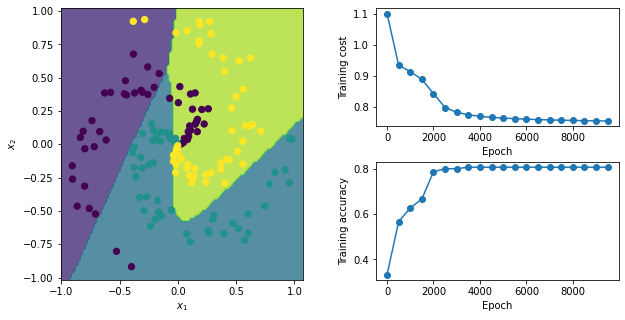

In [15]:
#Use sigmoid for the activation function of layer 1

class FeedforwardNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardNN, self).__init__()

        #layer sizes:
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        #functions used within the Feedforward NN:
        self.linear1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.linear2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.relu    = torch.nn.ReLU() 
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax()      
    def forward(self, x):
        #Layer 1:
        linear1_out = self.linear1(x)
        h1 = self.sigmoid(linear1_out)

        #Layer 2:
        linear2_out = self.linear2(h1)
        h2 = self.softmax(linear2_out)

        #Network output:
        y = h2

        return y

input_size = 2
hidden_size = 4
output_size = K
model = FeedforwardNN(input_size, hidden_size, output_size)

### Store the input data as a PyTorch tensor ###
x_train = torch.tensor(x_train, dtype = torch.float)

### One hot encoding ###
t_onehot = np.zeros((t_train.size, K))
t_onehot[np.arange(t_train.size),t_train] = 1
t_onehot = torch.tensor(t_onehot, dtype = torch.float)

### Use backpropagation to minimize the cost function using the gradient descent algorithm: ###
learning_rate = 1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Cost function: ###
cost_func = torch.nn.CrossEntropyLoss()

N_epochs = 10000 # number of times to run gradient descent


epoch_list    = []
cost_training = []
acc_training  = []

### Train for several epochs: ###
for epoch in range(N_epochs):

    optimizer.zero_grad() # sets the gradients to zero (necessary since PyTorch accumulates the gradients)
    NN_output = model(x_train) # Neural network output
    cost = cost_func(NN_output, t_onehot)
    cost.backward() #computes the gradients
    optimizer.step() #updating the parameters 

    ### Update the plot and print results every 500 epochs: ###
    if epoch % 500 == 0:
        predicted_class = np.argmax(NN_output.detach().numpy(), axis=1)
        accuracy = np.mean(predicted_class == t_train)
        
        epoch_list.append(epoch)
        cost_training.append(cost.detach().numpy())
        acc_training.append(accuracy)
        
        ### Update the plot of the resulting classifier: ###
        fig = plt.figure(2,figsize=(10,5))
        fig.subplots_adjust(hspace=.3,wspace=.3)
        plt.clf()
        updatePlot()
        display.display(plt.gcf())
        print("Iteration %d:\n  Training cost %f\n  Training accuracy %f\n" % (epoch, cost, accuracy) )
        display.clear_output(wait=True)
        # time.sleep(0.1) #Uncomment this line if you want to slow down the rate of plot updates

print("Final Training cost %f\nFinal Training accuracy %f\n" % (cost, accuracy) )

Final Training cost 0.810663
Final Training accuracy 0.740000



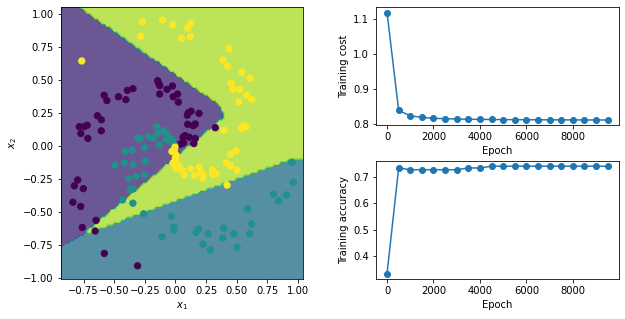

In [ ]:
#Use ReLu for the activation function of layer 1

class FeedforwardNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardNN, self).__init__()

        #layer sizes:
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        #functions used within the Feedforward NN:
        self.linear1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.linear2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.relu    = torch.nn.ReLU() 
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax()      
    def forward(self, x):
        #Layer 1:
        linear1_out = self.linear1(x)
        h1 = self.relu(linear1_out)

        #Layer 2:
        linear2_out = self.linear2(h1)
        h2 = self.softmax(linear2_out)

        #Network output:
        y = h2

        return y

input_size = 2
hidden_size = 4
output_size = K
model = FeedforwardNN(input_size, hidden_size, output_size)

### Store the input data as a PyTorch tensor ###
x_train = torch.tensor(x_train, dtype = torch.float)

### One hot encoding ###
t_onehot = np.zeros((t_train.size, K))
t_onehot[np.arange(t_train.size),t_train] = 1
t_onehot = torch.tensor(t_onehot, dtype = torch.float)

### Use backpropagation to minimize the cost function using the gradient descent algorithm: ###
learning_rate = 1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Cost function: ###
cost_func = torch.nn.CrossEntropyLoss()

N_epochs = 10000 # number of times to run gradient descent


epoch_list    = []
cost_training = []
acc_training  = []

### Train for several epochs: ###
for epoch in range(N_epochs):

    optimizer.zero_grad() # sets the gradients to zero (necessary since PyTorch accumulates the gradients)
    NN_output = model(x_train) # Neural network output
    cost = cost_func(NN_output, t_onehot)
    cost.backward() #computes the gradients
    optimizer.step() #updating the parameters 

    ### Update the plot and print results every 500 epochs: ###
    if epoch % 500 == 0:
        predicted_class = np.argmax(NN_output.detach().numpy(), axis=1)
        accuracy = np.mean(predicted_class == t_train)
        
        epoch_list.append(epoch)
        cost_training.append(cost.detach().numpy())
        acc_training.append(accuracy)
        
        ### Update the plot of the resulting classifier: ###
        fig = plt.figure(2,figsize=(10,5))
        fig.subplots_adjust(hspace=.3,wspace=.3)
        plt.clf()
        updatePlot()
        display.display(plt.gcf())
        print("Iteration %d:\n  Training cost %f\n  Training accuracy %f\n" % (epoch, cost, accuracy) )
        display.clear_output(wait=True)
        # time.sleep(0.1) #Uncomment this line if you want to slow down the rate of plot updates

print("Final Training cost %f\nFinal Training accuracy %f\n" % (cost, accuracy) )

Final Training cost 0.616034
Final Training accuracy 0.946667



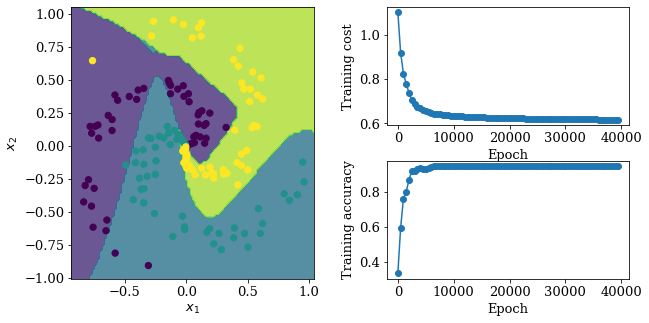

In [ ]:
#Studying the learning rate parameters, use sigmoid+1 hidden layer since it seems to be the best so far. 

#function to find nearest value in array
import math
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

class FeedforwardNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardNN, self).__init__()

        #layer sizes:
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        #functions used within the Feedforward NN:
        self.linear1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.linear2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.relu    = torch.nn.ReLU() 
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax()      
    def forward(self, x):
        #Layer 1:
        linear1_out = self.linear1(x)
        h1 = self.sigmoid(linear1_out)

        #Layer 2:
        linear2_out = self.linear2(h1)
        h2 = self.softmax(linear2_out)

        #Network output:
        y = h2

        return y

input_size = 2
hidden_size = 4
output_size = K

### Store the input data as a PyTorch tensor ###
x_train = torch.tensor(x_train, dtype = torch.float)


### One hot encoding ###
t_onehot = np.zeros((t_train.size, K))
t_onehot[np.arange(t_train.size),t_train] = 1
t_onehot = torch.tensor(t_onehot, dtype = torch.float)


### Cost function: ###
cost_func = torch.nn.CrossEntropyLoss()

N_epochs = 40000 # number of times to run gradient descent

costs = []
accuracies = []
best_epochs_80 = [] #epoch when accuracy=0.8 is first reached
best_epochs_85 = [] #epoch when accuracy=0.85 is first reached
best_epochs_90 = [] #epoch when accuracy=0.9 is first reached

learning_rates = np.linspace(0.1,2,20) #test a range of learning_rate

for i in learning_rates: 
    #print("Current learning rate is", i)
    model = FeedforwardNN(input_size, hidden_size, output_size)
    optimizer = torch.optim.SGD(model.parameters(), lr=i)

    epoch_list    = []
    cost_training = []
    acc_training  = []
    

    ### Train for several epochs: ###
    for epoch in range(N_epochs):

        optimizer.zero_grad() # sets the gradients to zero (necessary since PyTorch accumulates the gradients)
        NN_output = model(x_train) # Neural network output
        cost = cost_func(NN_output, t_onehot)
        cost.backward() #computes the gradients
        optimizer.step() #updating the parameters 

        ### Update the plot and print results every 500 epochs: ###
        if epoch % 500 == 0:
            predicted_class = np.argmax(NN_output.detach().numpy(), axis=1)
            accuracy = np.mean(predicted_class == t_train)
        
            epoch_list.append(epoch)
            cost_training.append(cost.detach().numpy())
            acc_training.append(accuracy)
        
            ### Update the plot of the resulting classifier: ###
            fig = plt.figure(2,figsize=(10,5))
            fig.subplots_adjust(hspace=.3,wspace=.3)
            plt.clf()
            updatePlot()
            display.display(plt.gcf())
            print("Learning rate %f\n Iteration %d:\n  Training cost %f\n  Training accuracy %f\n" % (i, epoch, cost, accuracy) )
            display.clear_output(wait=True)
            # time.sleep(0.1) #Uncomment this line if you want to slow down the rate of plot updates
    costs.append(cost.item())
    accuracies.append(accuracy)

    value = 0.8
    epoch_idx = find_nearest(acc_training, value)
    best_epochs_80.append(epoch_list[epoch_idx])

    value = 0.85
    epoch_idx = find_nearest(acc_training, value)
    best_epochs_85.append(epoch_list[epoch_idx])

    value = 0.9
    epoch_idx = find_nearest(acc_training, value)
    best_epochs_90.append(epoch_list[epoch_idx])

print("Final Training cost %f\nFinal Training accuracy %f\n" % (cost, accuracy) )



In [ ]:
print(acc_training)

import numpy as np
import math
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

value = 0.8

print(find_nearest(acc_training, value))


[0.3333333333333333, 0.5466666666666666, 0.8066666666666666, 0.8933333333333333, 0.9066666666666666, 0.9, 0.92, 0.9266666666666666, 0.9266666666666666, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.9466666666666667, 0.9466666666666667, 0.9466666666666667, 0.9466666666666667, 0.9466666666666667, 0.9466666666666667, 0.9466666666666667, 0.9466666666666667, 0.9466666666666667, 0.9466666666666667, 0.9466666666666667, 0.9466666666666667, 0.9466666666666667, 0.9466666666666667, 0.9466666666666667, 0.9466666666666667, 0.9466666666666667, 0.9466666666666667, 0.9533333333333334, 0.9533333333333334, 0.9533333333333334, 0.9533333333333334, 0.9533333333333334, 0.9533333333333334, 0.9533333333333334, 0.9533333333333334, 0.9533333333333334, 0.9533333333333334, 0.9533333333333334, 0.9533333333333334, 0.9533333333333334, 0.9533333333333334, 0.9533333333333334, 0.9533333333333334, 0.9533333333333334, 0.9533333333333334, 0.9533333333333334, 

[0.7945520281791687, 0.6785043478012085, 0.7284104824066162, 0.6372366547584534, 0.6288623809814453, 0.6155272126197815, 0.6241936087608337, 0.6068989038467407, 0.6337341666221619, 0.6126621961593628, 0.6000121235847473, 0.6427209377288818, 0.6122665405273438, 0.6197956204414368, 0.6199210286140442, 0.6002732515335083, 0.6047465801239014, 0.6216734647750854, 0.6101883053779602, 0.6160337328910828]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2. ]
[0.7866666666666666, 0.9133333333333333, 0.8333333333333334, 0.9333333333333333, 0.9466666666666667, 0.9466666666666667, 0.94, 0.9666666666666667, 0.94, 0.9533333333333334, 0.9666666666666667, 0.92, 0.9533333333333334, 0.9466666666666667, 0.9466666666666667, 0.9733333333333334, 0.9533333333333334, 0.94, 0.9533333333333334, 0.9466666666666667]


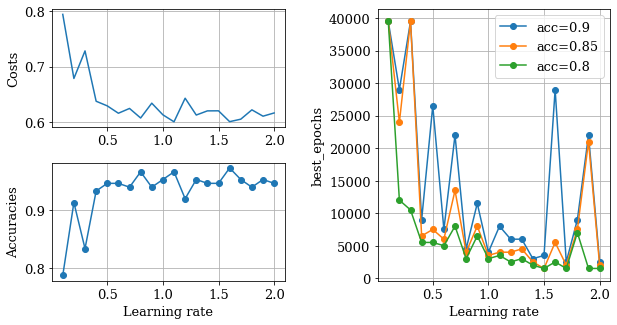

In [ ]:
import matplotlib as mpl
fig = plt.figure(2,figsize=(10,5))
mpl.rcParams.update({'font.size': 13,'font.family': 'serif'})

grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)

print(costs)
print(learning_rates)
print(accuracies)

ax = plt.subplot(grid[0, 0])
ax.plot(learning_rates,costs)
ax.set_ylabel("Costs")
ax.grid()

ax2 = plt.subplot(grid[1, 0])
ax2.plot(learning_rates,accuracies,marker='o')
ax2.set_xlabel("Learning rate")
ax2.set_ylabel("Accuracies")
ax2.grid()

ax3 = plt.subplot(grid[0:, 1])

ax3.plot(learning_rates,best_epochs_90,marker='o',label='acc=0.9')
ax3.plot(learning_rates,best_epochs_85,marker='o',label='acc=0.85')
ax3.plot(learning_rates,best_epochs_80,marker='o',label='acc=0.8')
ax3.set_xlabel("Learning rate")
ax3.set_ylabel("best_epochs")
plt.legend(loc=0)
ax3.grid()

Final Training cost 0.571747
Final Training accuracy 0.986667



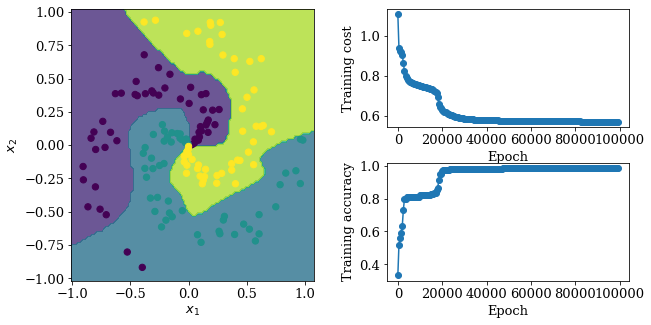

In [21]:
#Studying the effect of changing the number of neurons in the one hidden layer, use sigmoid since it seems to be the best so far. 

import math
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx


class FeedforwardNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardNN, self).__init__()

        #layer sizes:
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        #functions used within the Feedforward NN:
        self.linear1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.linear2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.relu    = torch.nn.ReLU() 
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax()      
    def forward(self, x):
        #Layer 1:
        linear1_out = self.linear1(x)
        h1 = self.sigmoid(linear1_out)

        #Layer 2:
        linear2_out = self.linear2(h1)
        h2 = self.softmax(linear2_out)

        #Network output:
        y = h2

        return y


### Store the input data as a PyTorch tensor ###
x_train = torch.tensor(x_train, dtype = torch.float)


### One hot encoding ###
t_onehot = np.zeros((t_train.size, K))
t_onehot[np.arange(t_train.size),t_train] = 1
t_onehot = torch.tensor(t_onehot, dtype = torch.float)


### Cost function: ###
cost_func = torch.nn.CrossEntropyLoss()

N_epochs = 100000 # number of times to run gradient descent

costs = []
accuracies = []
best_epochs_80 = [] #epoch when accuracy=0.8 is first reached
best_epochs_85 = [] #epoch when accuracy=0.85 is first reached
best_epochs_90 = [] #epoch when accuracy=0.9 is first reached

input_size = 2
output_size = K
hidden_sizes = np.linspace(1,10,10) #test a range of hidden_sizes
learning_rate = 0.7 #seems to be the best from previous cell

for i in hidden_sizes: 
    model = FeedforwardNN(input_size, int(i), output_size)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    epoch_list    = []
    cost_training = []
    acc_training  = []
    

    ### Train for several epochs: ###
    for epoch in range(N_epochs):

        optimizer.zero_grad() # sets the gradients to zero (necessary since PyTorch accumulates the gradients)
        NN_output = model(x_train) # Neural network output
        cost = cost_func(NN_output, t_onehot)
        cost.backward() #computes the gradients
        optimizer.step() #updating the parameters 

        ### Update the plot and print results every 500 epochs: ###
        if epoch % 500 == 0:
            predicted_class = np.argmax(NN_output.detach().numpy(), axis=1)
            accuracy = np.mean(predicted_class == t_train)
        
            epoch_list.append(epoch)
            cost_training.append(cost.detach().numpy())
            acc_training.append(accuracy)
        
            ### Update the plot of the resulting classifier: ###
            fig = plt.figure(2,figsize=(10,5))
            fig.subplots_adjust(hspace=.3,wspace=.3)
            plt.clf()
            updatePlot()
            display.display(plt.gcf())
            print("No. nodes in hidden layer %d\n Iteration %d:\n  Training cost %f\n  Training accuracy %f\n" % (i, epoch, cost, accuracy) )
            display.clear_output(wait=True)
            # time.sleep(0.1) #Uncomment this line if you want to slow down the rate of plot updates
    costs.append(cost.item())
    accuracies.append(accuracy)

    value = 0.8
    epoch_idx = find_nearest(acc_training, value)
    best_epochs_80.append(epoch_list[epoch_idx])

    value = 0.85
    epoch_idx = find_nearest(acc_training, value)
    best_epochs_85.append(epoch_list[epoch_idx])

    value = 0.9
    epoch_idx = find_nearest(acc_training, value)
    best_epochs_90.append(epoch_list[epoch_idx])

print("Final Training cost %f\nFinal Training accuracy %f\n" % (cost, accuracy) )



[0.9434359669685364, 0.8180064558982849, 0.7607476711273193, 0.7438938617706299, 0.7606591582298279, 0.6185818910598755, 0.7575074434280396, 0.751507043838501, 0.750420868396759, 0.7410869598388672]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[0.6333333333333333, 0.76, 0.8, 0.8333333333333334, 0.8, 0.9733333333333334, 0.8066666666666666, 0.82, 0.82, 0.82]


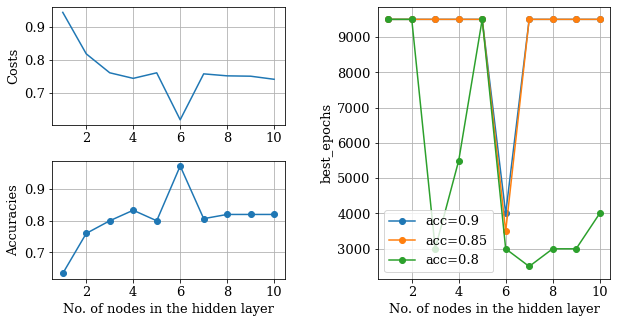

In [20]:
import matplotlib as mpl
fig = plt.figure(2,figsize=(10,5))
mpl.rcParams.update({'font.size': 13,'font.family': 'serif'})

grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)

print(costs)
print(hidden_sizes)
print(accuracies)

ax = plt.subplot(grid[0, 0])
ax.plot(hidden_sizes,costs)
ax.set_ylabel("Costs")
ax.grid()

ax2 = plt.subplot(grid[1, 0])
ax2.plot(hidden_sizes,accuracies,marker='o')
ax2.set_xlabel("No. of nodes in the hidden layer")
ax2.set_ylabel("Accuracies")
ax2.grid()

ax3 = plt.subplot(grid[0:, 1])

ax3.plot(hidden_sizes,best_epochs_90,marker='o',label='acc=0.9')
ax3.plot(hidden_sizes,best_epochs_85,marker='o',label='acc=0.85')
ax3.plot(hidden_sizes,best_epochs_80,marker='o',label='acc=0.8')
ax3.set_xlabel("No. of nodes in the hidden layer")
ax3.set_ylabel("best_epochs")
plt.legend(loc=0)
ax3.grid()